In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_13216\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_13216\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


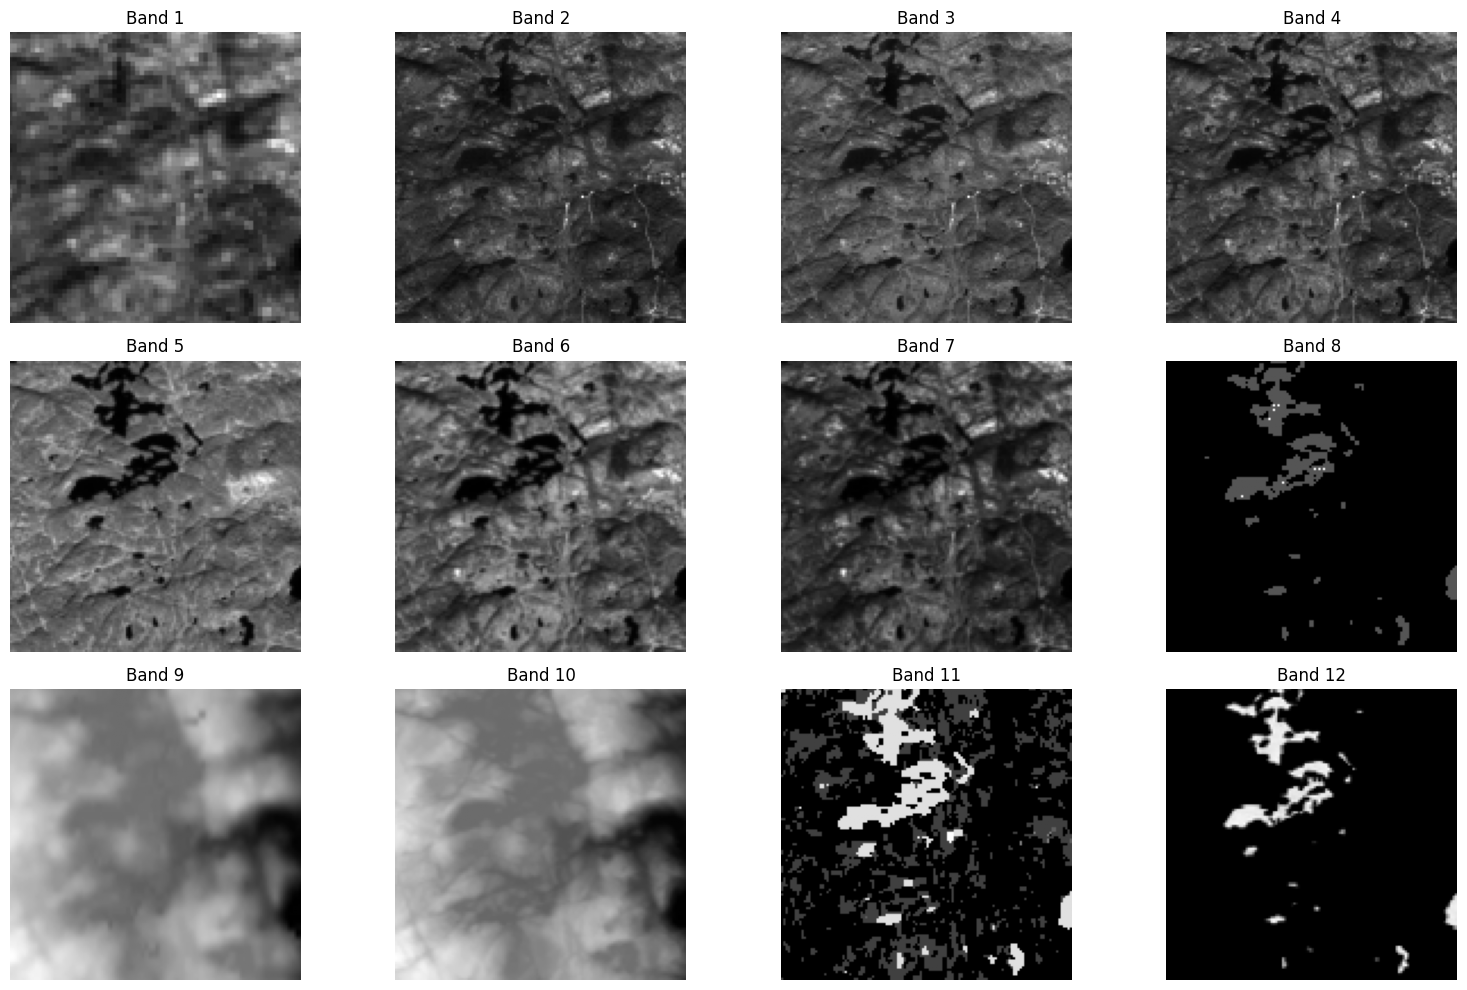

In [4]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model Arch

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [6]:
model = UNet(12, 1)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)


Total parameters: 7708161
Trainable parameters: 7708161


### Testing Diffrent Channels 

In [7]:
bands_A = list(range(12))
bands_B = [0, 1, 4, 5, 6, 11] # Costal + Blue  + NIR + SWIR1 + SWIR2 + Water Proba
bands_C = [3, 2, 1]  # R,G,B
bands_D = [4, 5, 6] # NIR + SWIR1 + SWIR2
bands_E = [0, 1, 4, 5, 6, 11]  # + NDWI computed later
bands_F = [2 , 3 , 4 , 5 , 6 , 10 , 11] # R + G + NIR + SWIR1 + SWIR2 +  Water Proba 


In [8]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, add_ndwi=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.add_ndwi = add_ndwi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            image = src.read()

        image = np.transpose(image, (1,2,0)).astype(np.float32)

        image = image[:, :, self.selected_bands]

        if self.add_ndwi:
            green = image[:, :, 2] if 2 in self.selected_bands else image[:, :, 1]
            nir = image[:, :, 4] if 4 in self.selected_bands else image[:, :, -1]

            ndwi = (green - nir) / (green + nir + 1e-8)
            ndwi = np.expand_dims(ndwi, axis=-1)

            image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [9]:
def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()

In [10]:
def train_model(selected_bands, add_ndwi=False, epochs=20):

    dataset = WaterDataset(image_dir, label_dir, selected_bands, add_ndwi)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    in_channels = len(selected_bands) + (1 if add_ndwi else 0)
    model = UNet(in_channels=in_channels, out_channels=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []
    train_ious, val_ious = [], []

    for epoch in range(epochs):

        # ---------------- TRAIN ----------------
        model.train()
        train_loss = 0
        train_iou = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            train_iou += iou

            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        train_losses.append(train_loss)
        train_ious.append(train_iou)


        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        val_iou = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()

                iou  = calculate_metrics(preds, masks)
                val_iou += iou

                val_bar.set_postfix(val_loss=loss.item())

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        val_losses.append(val_loss)
        val_ious.append(val_iou)

        print(f"\nEpoch {epoch+1}")
        print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
        print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}")

    return {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_ious": train_ious,
        "val_ious": val_ious,
    }


In [11]:
results = {}

print("\n" + "="*60)
print("Training Model: All 12 Bands")
print("="*60)
results["All 12"] = train_model(bands_A)

print("\n" + "="*60)
print("Training Model: 6 Water Bands")
print("="*60)
results["6 Water Bands"] = train_model(bands_B)

print("\n" + "="*60)
print("Training Model: RGB")
print("="*60)
results["RGB"] = train_model(bands_C)

print("\n" + "="*60)
print("Training Model: NIR + SWIR")
print("="*60)
results["NIR+SWIR"] = train_model(bands_D)

print("\n" + "="*60)
print("Training Model: 6 Bands + NDWI")
print("="*60)
results["6 Bands + NDWI"] = train_model(bands_B, add_ndwi=True)

print("\n" + "="*60)
print("Training Model: 7 Bands")
print("="*60)
results["7 Bands"] = train_model(bands_F)



Training Model: All 12 Bands


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s, val_loss=0.64] 



Epoch 1
Train -> Loss:0.5682 | IoU:0.4308
Val   -> Loss:0.6577 | IoU:0.1256


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.577]



Epoch 2
Train -> Loss:0.4551 | IoU:0.5457
Val   -> Loss:0.5914 | IoU:0.1233


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.573]



Epoch 3
Train -> Loss:0.4112 | IoU:0.5703
Val   -> Loss:0.5831 | IoU:0.1228


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.571]



Epoch 4
Train -> Loss:0.3882 | IoU:0.5904
Val   -> Loss:0.5809 | IoU:0.1233


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s, val_loss=0.581]



Epoch 5
Train -> Loss:0.3784 | IoU:0.5842
Val   -> Loss:0.5877 | IoU:0.1233


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s, val_loss=0.577]



Epoch 6
Train -> Loss:0.3652 | IoU:0.5837
Val   -> Loss:0.5840 | IoU:0.1233


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.596]



Epoch 7
Train -> Loss:0.3359 | IoU:0.6408
Val   -> Loss:0.6003 | IoU:0.1233


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.44it/s, val_loss=0.603]



Epoch 8
Train -> Loss:0.3454 | IoU:0.6122
Val   -> Loss:0.6097 | IoU:0.1233


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.576]



Epoch 9
Train -> Loss:0.3423 | IoU:0.5856
Val   -> Loss:0.5872 | IoU:0.1233


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.592]



Epoch 10
Train -> Loss:0.3338 | IoU:0.6240
Val   -> Loss:0.5956 | IoU:0.1233


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.598]



Epoch 11
Train -> Loss:0.3256 | IoU:0.6203
Val   -> Loss:0.6016 | IoU:0.1233


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.613]



Epoch 12
Train -> Loss:0.3264 | IoU:0.6207
Val   -> Loss:0.6149 | IoU:0.1233


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.61] 



Epoch 13
Train -> Loss:0.3115 | IoU:0.6349
Val   -> Loss:0.6128 | IoU:0.1233


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, val_loss=0.606]



Epoch 14
Train -> Loss:0.3317 | IoU:0.5785
Val   -> Loss:0.6081 | IoU:0.1233


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s, val_loss=0.59] 



Epoch 15
Train -> Loss:0.3188 | IoU:0.6034
Val   -> Loss:0.5946 | IoU:0.1233


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, val_loss=0.604]



Epoch 16
Train -> Loss:0.3004 | IoU:0.6375
Val   -> Loss:0.6068 | IoU:0.1233


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.597]



Epoch 17
Train -> Loss:0.3009 | IoU:0.6390
Val   -> Loss:0.5999 | IoU:0.1233


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.637]



Epoch 18
Train -> Loss:0.2939 | IoU:0.6350
Val   -> Loss:0.6385 | IoU:0.1233


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.573]



Epoch 19
Train -> Loss:0.2923 | IoU:0.6275
Val   -> Loss:0.5773 | IoU:0.1233


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.567]



Epoch 20
Train -> Loss:0.2821 | IoU:0.6552
Val   -> Loss:0.5777 | IoU:0.1233

Training Model: 6 Water Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.25it/s, val_loss=0.648]



Epoch 1
Train -> Loss:0.5249 | IoU:0.4694
Val   -> Loss:0.6479 | IoU:0.2729


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.549]



Epoch 2
Train -> Loss:0.4071 | IoU:0.5906
Val   -> Loss:0.5361 | IoU:0.3594


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s, val_loss=0.523]



Epoch 3
Train -> Loss:0.3684 | IoU:0.6250
Val   -> Loss:0.5167 | IoU:0.5260


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.44it/s, val_loss=0.37] 



Epoch 4
Train -> Loss:0.3528 | IoU:0.6263
Val   -> Loss:0.3593 | IoU:0.6390


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.351]



Epoch 5
Train -> Loss:0.3297 | IoU:0.6640
Val   -> Loss:0.3509 | IoU:0.6592


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=0.372]



Epoch 6
Train -> Loss:0.3269 | IoU:0.6719
Val   -> Loss:0.3852 | IoU:0.6378


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.71it/s, val_loss=0.357]



Epoch 7
Train -> Loss:0.3238 | IoU:0.6490
Val   -> Loss:0.3445 | IoU:0.6576


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s, val_loss=0.348]



Epoch 8
Train -> Loss:0.3109 | IoU:0.6701
Val   -> Loss:0.3464 | IoU:0.6474


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.334]



Epoch 9
Train -> Loss:0.3136 | IoU:0.6496
Val   -> Loss:0.3254 | IoU:0.6465


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.312]



Epoch 10
Train -> Loss:0.3071 | IoU:0.6652
Val   -> Loss:0.3090 | IoU:0.6983


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s, val_loss=0.323]



Epoch 11
Train -> Loss:0.2891 | IoU:0.6855
Val   -> Loss:0.3176 | IoU:0.6904


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s, val_loss=0.302]



Epoch 12
Train -> Loss:0.2810 | IoU:0.6998
Val   -> Loss:0.3068 | IoU:0.6883


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.357]



Epoch 13
Train -> Loss:0.2870 | IoU:0.6828
Val   -> Loss:0.3656 | IoU:0.6328


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.303]



Epoch 14
Train -> Loss:0.2735 | IoU:0.6946
Val   -> Loss:0.3120 | IoU:0.6926


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.288]



Epoch 15
Train -> Loss:0.2626 | IoU:0.7132
Val   -> Loss:0.2959 | IoU:0.7025


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.319]



Epoch 16
Train -> Loss:0.2732 | IoU:0.6811
Val   -> Loss:0.3043 | IoU:0.6664


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s, val_loss=0.295]



Epoch 17
Train -> Loss:0.2723 | IoU:0.7025
Val   -> Loss:0.2944 | IoU:0.7017


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.302]



Epoch 18
Train -> Loss:0.2546 | IoU:0.7087
Val   -> Loss:0.3131 | IoU:0.7015


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.28it/s, val_loss=0.289]



Epoch 19
Train -> Loss:0.2520 | IoU:0.7111
Val   -> Loss:0.2976 | IoU:0.6963


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s, val_loss=0.289]



Epoch 20
Train -> Loss:0.2478 | IoU:0.7172
Val   -> Loss:0.2934 | IoU:0.6901

Training Model: RGB


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s, val_loss=0.705]



Epoch 1
Train -> Loss:0.6330 | IoU:0.2846
Val   -> Loss:0.7037 | IoU:0.2950


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.77it/s, val_loss=1.04] 



Epoch 2
Train -> Loss:0.5695 | IoU:0.3570
Val   -> Loss:1.0551 | IoU:0.2993


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s, val_loss=0.794]



Epoch 3
Train -> Loss:0.5186 | IoU:0.3913
Val   -> Loss:0.8435 | IoU:0.3170


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, val_loss=0.648]



Epoch 4
Train -> Loss:0.4851 | IoU:0.4091
Val   -> Loss:0.6258 | IoU:0.3606


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.774]



Epoch 5
Train -> Loss:0.4957 | IoU:0.3577
Val   -> Loss:0.7196 | IoU:0.3585


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s, val_loss=0.598]



Epoch 6
Train -> Loss:0.4632 | IoU:0.4162
Val   -> Loss:0.5358 | IoU:0.3608


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s, val_loss=0.612]



Epoch 7
Train -> Loss:0.4432 | IoU:0.4195
Val   -> Loss:0.5562 | IoU:0.3721


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s, val_loss=0.544]



Epoch 8
Train -> Loss:0.4230 | IoU:0.4366
Val   -> Loss:0.4967 | IoU:0.3557


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.506]



Epoch 9
Train -> Loss:0.4158 | IoU:0.4436
Val   -> Loss:0.4812 | IoU:0.3673


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.70it/s, val_loss=0.56] 



Epoch 10
Train -> Loss:0.4138 | IoU:0.4524
Val   -> Loss:0.5153 | IoU:0.3852


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s, val_loss=0.514]



Epoch 11
Train -> Loss:0.4104 | IoU:0.4508
Val   -> Loss:0.4737 | IoU:0.4091


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s, val_loss=0.724]



Epoch 12
Train -> Loss:0.4249 | IoU:0.4305
Val   -> Loss:0.5992 | IoU:0.3693


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, val_loss=0.552]



Epoch 13
Train -> Loss:0.4212 | IoU:0.4253
Val   -> Loss:0.5195 | IoU:0.3781


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.48] 



Epoch 14
Train -> Loss:0.4000 | IoU:0.4381
Val   -> Loss:0.4599 | IoU:0.3919


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.503]



Epoch 15
Train -> Loss:0.3753 | IoU:0.5098
Val   -> Loss:0.4676 | IoU:0.4272


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.64it/s, val_loss=0.48] 



Epoch 16
Train -> Loss:0.3777 | IoU:0.5076
Val   -> Loss:0.4477 | IoU:0.4260


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.517]



Epoch 17
Train -> Loss:0.4057 | IoU:0.4391
Val   -> Loss:0.4873 | IoU:0.3923


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.561]



Epoch 18
Train -> Loss:0.4027 | IoU:0.4511
Val   -> Loss:0.4857 | IoU:0.3611


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.472]



Epoch 19
Train -> Loss:0.3767 | IoU:0.4682
Val   -> Loss:0.4355 | IoU:0.4185


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s, val_loss=0.489]



Epoch 20
Train -> Loss:0.3713 | IoU:0.4850
Val   -> Loss:0.4388 | IoU:0.4305

Training Model: NIR + SWIR


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, val_loss=0.633]



Epoch 1
Train -> Loss:0.5215 | IoU:0.5037
Val   -> Loss:0.6249 | IoU:0.0000


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.522]



Epoch 2
Train -> Loss:0.4280 | IoU:0.5912
Val   -> Loss:0.5067 | IoU:0.4511


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, val_loss=0.497]



Epoch 3
Train -> Loss:0.3844 | IoU:0.6249
Val   -> Loss:0.4697 | IoU:0.4668


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.445]



Epoch 4
Train -> Loss:0.3611 | IoU:0.6361
Val   -> Loss:0.3857 | IoU:0.4651


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s, val_loss=0.418]



Epoch 5
Train -> Loss:0.3557 | IoU:0.6445
Val   -> Loss:0.3880 | IoU:0.4832


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s, val_loss=0.452]



Epoch 6
Train -> Loss:0.3550 | IoU:0.6317
Val   -> Loss:0.4204 | IoU:0.4547


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=0.445]



Epoch 7
Train -> Loss:0.3283 | IoU:0.6747
Val   -> Loss:0.4079 | IoU:0.4707


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s, val_loss=0.414]



Epoch 8
Train -> Loss:0.3336 | IoU:0.6453
Val   -> Loss:0.3771 | IoU:0.5174


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s, val_loss=0.429]



Epoch 9
Train -> Loss:0.3278 | IoU:0.6483
Val   -> Loss:0.3822 | IoU:0.4937


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, val_loss=0.439]



Epoch 10
Train -> Loss:0.3101 | IoU:0.6776
Val   -> Loss:0.3896 | IoU:0.5243


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s, val_loss=0.401]



Epoch 11
Train -> Loss:0.3082 | IoU:0.6681
Val   -> Loss:0.3718 | IoU:0.5302


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s, val_loss=0.427]



Epoch 12
Train -> Loss:0.3178 | IoU:0.6486
Val   -> Loss:0.3795 | IoU:0.4998


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.408]



Epoch 13
Train -> Loss:0.3049 | IoU:0.6754
Val   -> Loss:0.3859 | IoU:0.4872


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.436]



Epoch 14
Train -> Loss:0.3020 | IoU:0.6512
Val   -> Loss:0.3701 | IoU:0.5208


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.54it/s, val_loss=0.418]



Epoch 15
Train -> Loss:0.3096 | IoU:0.6800
Val   -> Loss:0.3742 | IoU:0.4810


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, val_loss=0.424]



Epoch 16
Train -> Loss:0.2833 | IoU:0.6859
Val   -> Loss:0.3689 | IoU:0.5209


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.438]



Epoch 17
Train -> Loss:0.2787 | IoU:0.6976
Val   -> Loss:0.3698 | IoU:0.5219


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s, val_loss=0.42] 



Epoch 18
Train -> Loss:0.2759 | IoU:0.6943
Val   -> Loss:0.3419 | IoU:0.5423


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.431]



Epoch 19
Train -> Loss:0.2688 | IoU:0.6868
Val   -> Loss:0.3634 | IoU:0.5361


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, val_loss=0.418]



Epoch 20
Train -> Loss:0.3023 | IoU:0.6421
Val   -> Loss:0.3577 | IoU:0.5462

Training Model: 6 Bands + NDWI


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s, val_loss=0.647]



Epoch 1
Train -> Loss:0.4743 | IoU:0.4951
Val   -> Loss:0.6451 | IoU:0.0942


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.484]



Epoch 2
Train -> Loss:0.3780 | IoU:0.5992
Val   -> Loss:0.4656 | IoU:0.4139


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, val_loss=0.324]



Epoch 3
Train -> Loss:0.3607 | IoU:0.5989
Val   -> Loss:0.3269 | IoU:0.7080


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.294]



Epoch 4
Train -> Loss:0.3395 | IoU:0.6285
Val   -> Loss:0.3083 | IoU:0.7154


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s, val_loss=0.272]



Epoch 5
Train -> Loss:0.3280 | IoU:0.6381
Val   -> Loss:0.2852 | IoU:0.7301


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.266]



Epoch 6
Train -> Loss:0.3167 | IoU:0.6467
Val   -> Loss:0.2804 | IoU:0.7237


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.244]



Epoch 7
Train -> Loss:0.3200 | IoU:0.6474
Val   -> Loss:0.2576 | IoU:0.7446


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.27] 



Epoch 8
Train -> Loss:0.3193 | IoU:0.6181
Val   -> Loss:0.2884 | IoU:0.7238


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.242]



Epoch 9
Train -> Loss:0.3035 | IoU:0.6657
Val   -> Loss:0.2551 | IoU:0.7440


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.236]



Epoch 10
Train -> Loss:0.2980 | IoU:0.6541
Val   -> Loss:0.2403 | IoU:0.7404


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.259]



Epoch 11
Train -> Loss:0.2794 | IoU:0.6839
Val   -> Loss:0.2672 | IoU:0.7414


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.235]



Epoch 12
Train -> Loss:0.2941 | IoU:0.6448
Val   -> Loss:0.2571 | IoU:0.7454


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.235]



Epoch 13
Train -> Loss:0.2767 | IoU:0.6805
Val   -> Loss:0.2444 | IoU:0.7463


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.234]



Epoch 14
Train -> Loss:0.2796 | IoU:0.6711
Val   -> Loss:0.2338 | IoU:0.7478


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.247]



Epoch 15
Train -> Loss:0.2851 | IoU:0.6526
Val   -> Loss:0.2587 | IoU:0.7205


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.239]



Epoch 16
Train -> Loss:0.2584 | IoU:0.7064
Val   -> Loss:0.2492 | IoU:0.7449


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, val_loss=0.237]



Epoch 17
Train -> Loss:0.2553 | IoU:0.6950
Val   -> Loss:0.2377 | IoU:0.7578


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.236]



Epoch 18
Train -> Loss:0.2538 | IoU:0.6890
Val   -> Loss:0.2378 | IoU:0.7551


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.215]



Epoch 19
Train -> Loss:0.2673 | IoU:0.6734
Val   -> Loss:0.2307 | IoU:0.7546


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.2]  



Epoch 20
Train -> Loss:0.2564 | IoU:0.6837
Val   -> Loss:0.2122 | IoU:0.7436

Training Model: 7 Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.72it/s, val_loss=0.662]



Epoch 1
Train -> Loss:0.5862 | IoU:0.4669
Val   -> Loss:0.6476 | IoU:0.0454


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.546]



Epoch 2
Train -> Loss:0.4639 | IoU:0.5341
Val   -> Loss:0.5655 | IoU:0.2597


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.462]



Epoch 3
Train -> Loss:0.4211 | IoU:0.5530
Val   -> Loss:0.4842 | IoU:0.3464


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s, val_loss=0.454]



Epoch 4
Train -> Loss:0.4049 | IoU:0.5851
Val   -> Loss:0.5383 | IoU:0.4361


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.454]



Epoch 5
Train -> Loss:0.3695 | IoU:0.6220
Val   -> Loss:0.4509 | IoU:0.4184


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.415]



Epoch 6
Train -> Loss:0.3725 | IoU:0.5917
Val   -> Loss:0.4421 | IoU:0.4163


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.465]



Epoch 7
Train -> Loss:0.3563 | IoU:0.6060
Val   -> Loss:0.5280 | IoU:0.6031


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.469]



Epoch 8
Train -> Loss:0.3489 | IoU:0.6080
Val   -> Loss:0.5037 | IoU:0.5873


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.424]



Epoch 9
Train -> Loss:0.3543 | IoU:0.6002
Val   -> Loss:0.4802 | IoU:0.3942


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, val_loss=0.445]



Epoch 10
Train -> Loss:0.3417 | IoU:0.6007
Val   -> Loss:0.5118 | IoU:0.5578


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.505]



Epoch 11
Train -> Loss:0.3331 | IoU:0.6510
Val   -> Loss:0.5755 | IoU:0.6004


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.505]



Epoch 12
Train -> Loss:0.3376 | IoU:0.6223
Val   -> Loss:0.5997 | IoU:0.5694


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.572]



Epoch 13
Train -> Loss:0.3179 | IoU:0.6473
Val   -> Loss:0.6253 | IoU:0.4741


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.388]



Epoch 14
Train -> Loss:0.3173 | IoU:0.6542
Val   -> Loss:0.4777 | IoU:0.5510


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.419]



Epoch 15
Train -> Loss:0.3263 | IoU:0.6178
Val   -> Loss:0.4630 | IoU:0.4846


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.378]



Epoch 16
Train -> Loss:0.3055 | IoU:0.6501
Val   -> Loss:0.4065 | IoU:0.5333


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.468]



Epoch 17
Train -> Loss:0.3032 | IoU:0.6673
Val   -> Loss:0.5631 | IoU:0.6323


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, val_loss=0.597]



Epoch 18
Train -> Loss:0.3205 | IoU:0.6239
Val   -> Loss:0.5309 | IoU:0.5330


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.47] 



Epoch 19
Train -> Loss:0.3330 | IoU:0.6363
Val   -> Loss:0.4962 | IoU:0.5716


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.33] 


Epoch 20
Train -> Loss:0.2958 | IoU:0.6663
Val   -> Loss:0.3971 | IoU:0.6302


In [12]:
print("\n" + "="*60)
print("IoU Comparison")
print("="*60)

sorted_results = sorted(
    results.items(),
    key=lambda x: x[1]["val_ious"][-1],  
    reverse=True
)

for i, (name, data) in enumerate(sorted_results, 1):
    final_iou = data["val_ious"][-1]
    print(f"{i}. {name:<20} | IoU: {final_iou:.4f}")



IoU Comparison
1. 6 Bands + NDWI       | IoU: 0.7436
2. 6 Water Bands        | IoU: 0.6901
3. 7 Bands              | IoU: 0.6302
4. NIR+SWIR             | IoU: 0.5462
5. RGB                  | IoU: 0.4305
6. All 12               | IoU: 0.1233


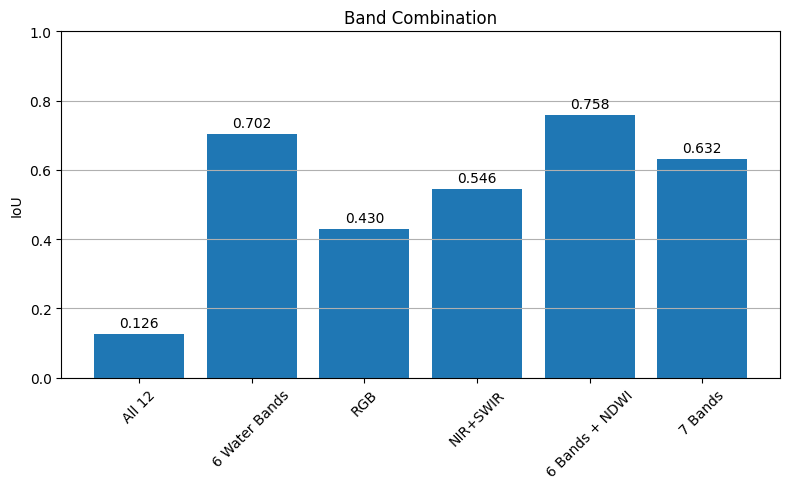

In [13]:
model_names = []
iou_scores = []

for name, data in results.items():
    best_iou = max(data["val_ious"])   # best validation IoU
    model_names.append(name)
    iou_scores.append(best_iou)

plt.figure(figsize=(8,5))
plt.bar(model_names, iou_scores)

plt.xticks(rotation=45)
plt.ylabel("IoU")
plt.title("Band Combination")
plt.ylim(0, 1)
plt.grid(axis="y")

for i, v in enumerate(iou_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

### Model A (6 Bands)

In [14]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


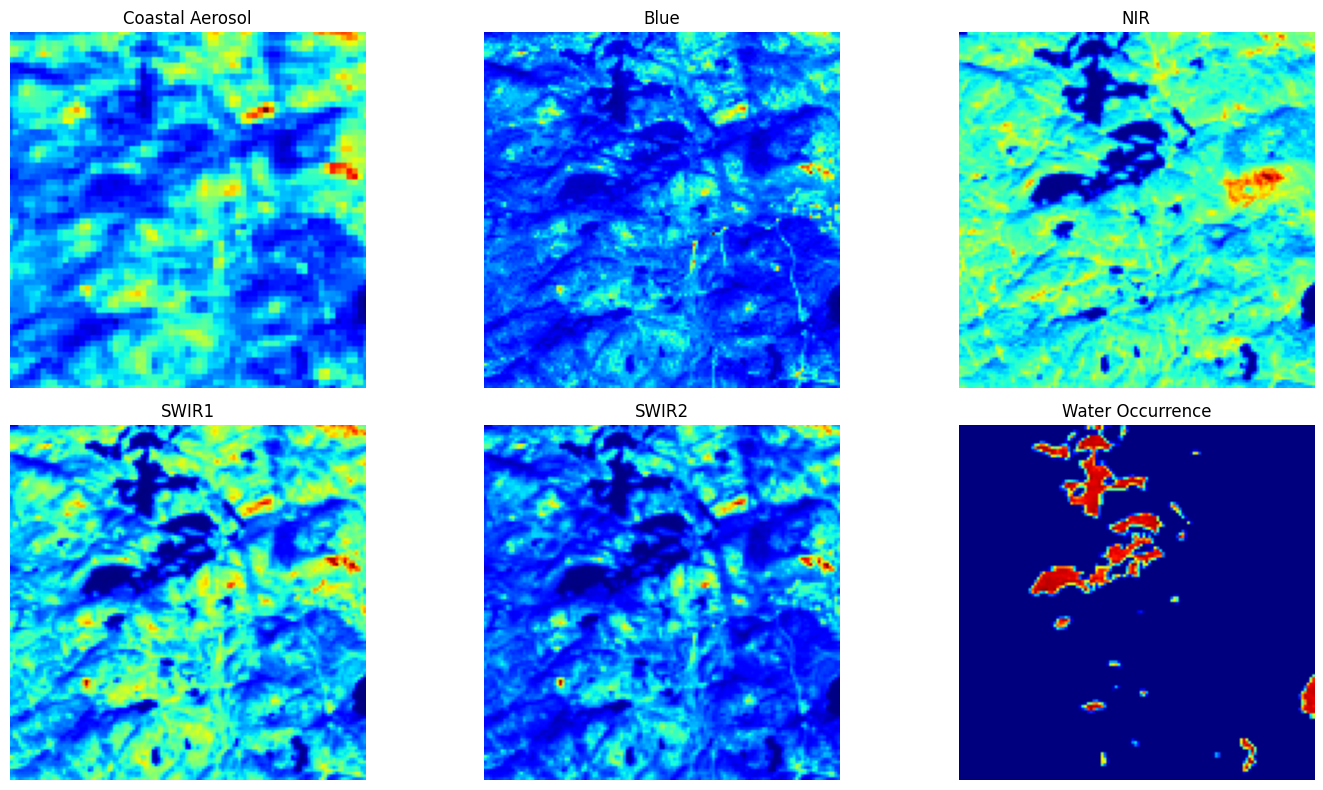

In [15]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
from torch.utils.data import Subset

dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



In [17]:
model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [18]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item() 


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou  = calculate_metrics(preds, masks)

            val_iou += iou

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")



Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.678]



Epoch 1
Train -> Loss:0.5516 | IoU:0.4827
Val   -> Loss:0.6742 | IoU:0.4322



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s, val_loss=0.551]



Epoch 2
Train -> Loss:0.4479 | IoU:0.5873
Val   -> Loss:0.5366 | IoU:0.5821



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.423]



Epoch 3
Train -> Loss:0.4097 | IoU:0.6222
Val   -> Loss:0.4184 | IoU:0.6561



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s, val_loss=0.39] 



Epoch 4
Train -> Loss:0.3916 | IoU:0.6335
Val   -> Loss:0.3738 | IoU:0.6728



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, val_loss=0.397]



Epoch 5
Train -> Loss:0.3798 | IoU:0.6267
Val   -> Loss:0.3727 | IoU:0.6528



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s, val_loss=0.386]



Epoch 6
Train -> Loss:0.3698 | IoU:0.6261
Val   -> Loss:0.3719 | IoU:0.6600



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.385]



Epoch 7
Train -> Loss:0.3539 | IoU:0.6586
Val   -> Loss:0.3459 | IoU:0.6431



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.348]



Epoch 8
Train -> Loss:0.3416 | IoU:0.6784
Val   -> Loss:0.3268 | IoU:0.6779



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.354]



Epoch 9
Train -> Loss:0.3357 | IoU:0.6946
Val   -> Loss:0.3186 | IoU:0.6532



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.345]



Epoch 10
Train -> Loss:0.3428 | IoU:0.6179
Val   -> Loss:0.3077 | IoU:0.6577



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.376]



Epoch 11
Train -> Loss:0.3200 | IoU:0.6783
Val   -> Loss:0.3602 | IoU:0.6253



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.328]



Epoch 12
Train -> Loss:0.3211 | IoU:0.6451
Val   -> Loss:0.3054 | IoU:0.6824



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.385]



Epoch 13
Train -> Loss:0.2987 | IoU:0.7229
Val   -> Loss:0.3431 | IoU:0.6535



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.305]



Epoch 14
Train -> Loss:0.2903 | IoU:0.7260
Val   -> Loss:0.2863 | IoU:0.6978



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.373]



Epoch 15
Train -> Loss:0.2823 | IoU:0.7236
Val   -> Loss:0.3277 | IoU:0.6383



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.334]



Epoch 16
Train -> Loss:0.2881 | IoU:0.7052
Val   -> Loss:0.2977 | IoU:0.6930



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.309]



Epoch 17
Train -> Loss:0.2741 | IoU:0.7262
Val   -> Loss:0.2846 | IoU:0.6902



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.299]



Epoch 18
Train -> Loss:0.2597 | IoU:0.7578
Val   -> Loss:0.2692 | IoU:0.7154



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s, val_loss=0.311]



Epoch 19
Train -> Loss:0.2629 | IoU:0.7403
Val   -> Loss:0.2798 | IoU:0.7097



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.307]


Epoch 20
Train -> Loss:0.2706 | IoU:0.7121
Val   -> Loss:0.2663 | IoU:0.7075



In [19]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


Eval:
Precision: 0.6892
Recall:    0.9612
IoU:       0.6706
F1-score:  0.8028


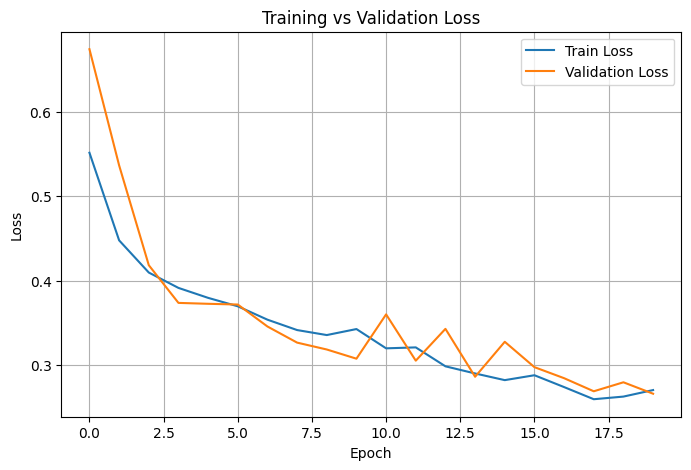

In [20]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


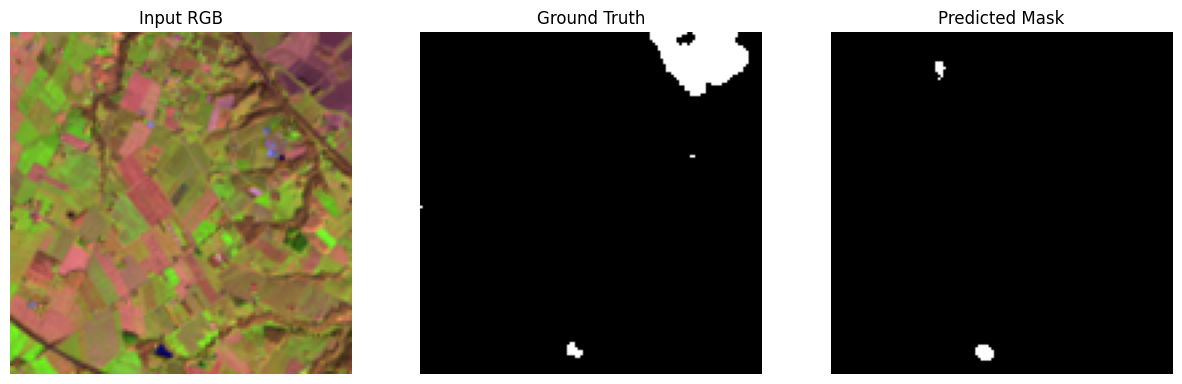

In [21]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


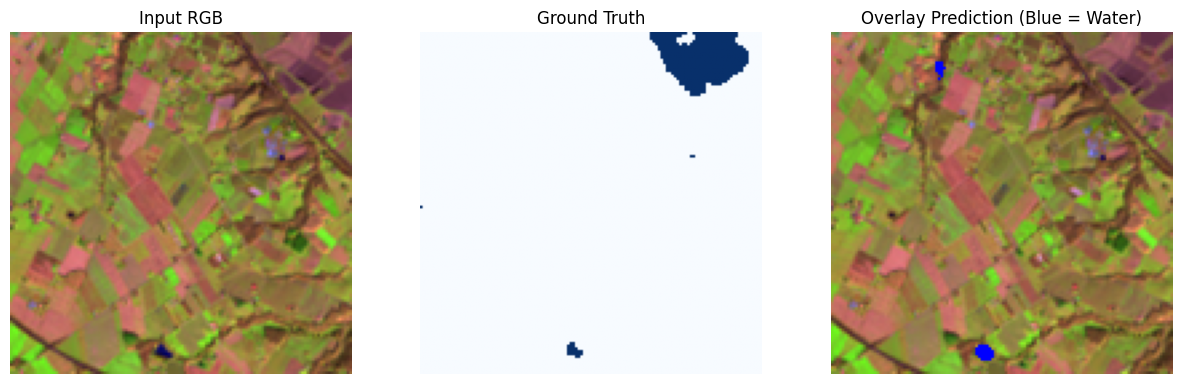

In [22]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model B (6 Bands + NDWI)

In [23]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [0, 1, 4, 5, 6, 11]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]

        green = full_image[:, :, 2]
        nir = full_image[:, :, 4]

        ndwi = (green - nir) / (green + nir + 1e-8)
        ndwi = np.expand_dims(ndwi, axis=-1)
        image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=7, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [25]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [26]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)


    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            val_iou += iou


            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)


    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.91it/s, val_loss=0.68] 



Epoch 1
Train -> Loss:0.5524 | IoU:0.4909
Val   -> Loss:0.6827 | IoU:0.3175



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s, val_loss=0.512]



Epoch 2
Train -> Loss:0.4372 | IoU:0.6078
Val   -> Loss:0.5126 | IoU:0.5483



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.388]



Epoch 3
Train -> Loss:0.3979 | IoU:0.6504
Val   -> Loss:0.3953 | IoU:0.6143



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, val_loss=0.382]



Epoch 4
Train -> Loss:0.3766 | IoU:0.6717
Val   -> Loss:0.3899 | IoU:0.5961



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, val_loss=0.377]



Epoch 5
Train -> Loss:0.3699 | IoU:0.6508
Val   -> Loss:0.3895 | IoU:0.5986



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.365]



Epoch 6
Train -> Loss:0.3749 | IoU:0.6334
Val   -> Loss:0.3656 | IoU:0.6039



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.36] 



Epoch 7
Train -> Loss:0.3512 | IoU:0.6775
Val   -> Loss:0.3653 | IoU:0.5983



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.373]



Epoch 8
Train -> Loss:0.3520 | IoU:0.6504
Val   -> Loss:0.3768 | IoU:0.5712



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.331]



Epoch 9
Train -> Loss:0.3269 | IoU:0.6967
Val   -> Loss:0.3237 | IoU:0.6584



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, val_loss=0.334]



Epoch 10
Train -> Loss:0.3250 | IoU:0.6827
Val   -> Loss:0.3339 | IoU:0.6390



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.371]



Epoch 11
Train -> Loss:0.3161 | IoU:0.6914
Val   -> Loss:0.3831 | IoU:0.5553



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.31] 



Epoch 12
Train -> Loss:0.3048 | IoU:0.7189
Val   -> Loss:0.2971 | IoU:0.6498



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.329]



Epoch 13
Train -> Loss:0.3054 | IoU:0.6897
Val   -> Loss:0.3178 | IoU:0.6482



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.327]



Epoch 14
Train -> Loss:0.2986 | IoU:0.7086
Val   -> Loss:0.3201 | IoU:0.6147



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s, val_loss=0.349]



Epoch 15
Train -> Loss:0.2889 | IoU:0.7148
Val   -> Loss:0.3384 | IoU:0.6090



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, val_loss=0.304]



Epoch 16
Train -> Loss:0.2819 | IoU:0.7369
Val   -> Loss:0.2903 | IoU:0.6464



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.285]



Epoch 17
Train -> Loss:0.2780 | IoU:0.7138
Val   -> Loss:0.2831 | IoU:0.6502



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s, val_loss=0.296]



Epoch 18
Train -> Loss:0.2845 | IoU:0.7059
Val   -> Loss:0.2846 | IoU:0.6440



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.287]



Epoch 19
Train -> Loss:0.2726 | IoU:0.7232
Val   -> Loss:0.2754 | IoU:0.6417



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.301]


Epoch 20
Train -> Loss:0.2628 | IoU:0.7321
Val   -> Loss:0.2772 | IoU:0.6453



In [27]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Eval:
Precision: 0.6925
Recall:    0.9301
IoU:       0.6582
F1-score:  0.7939


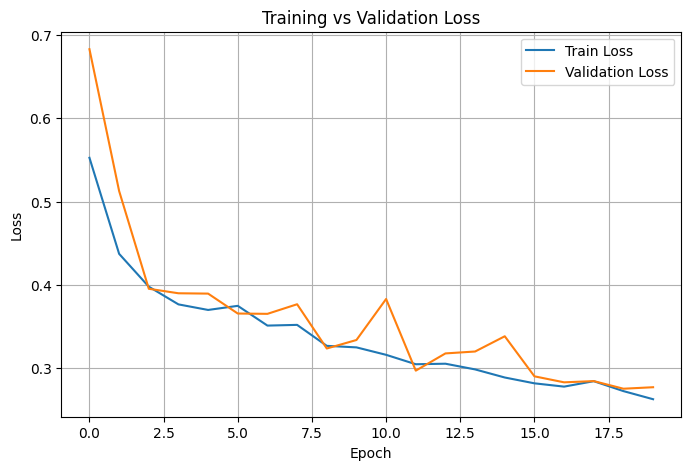

In [28]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


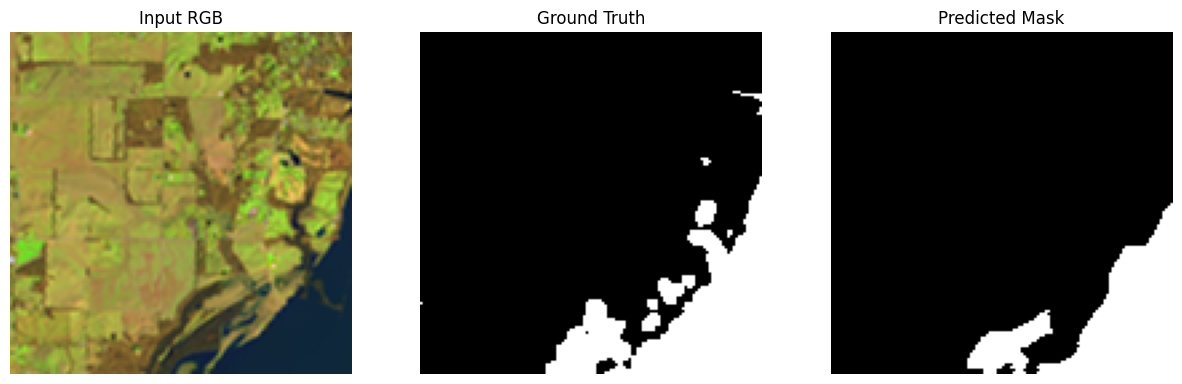

In [29]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


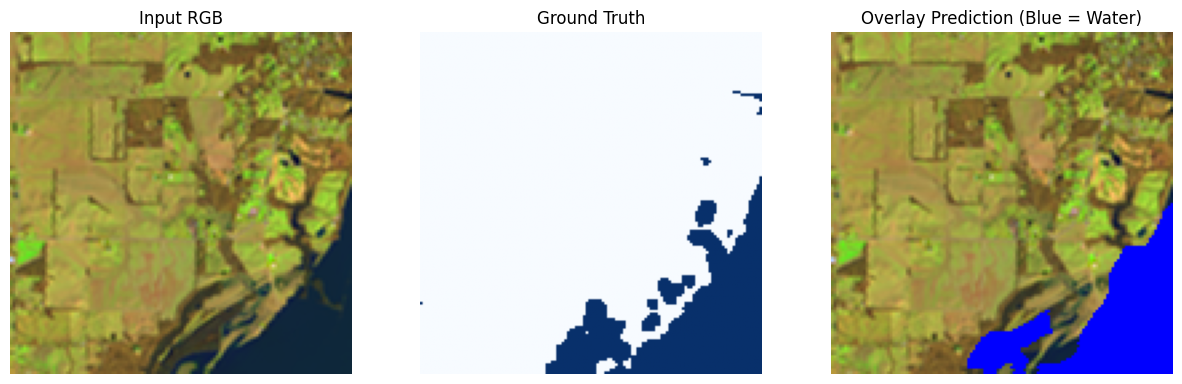

In [30]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model C ---> NIR+SWIR

In [31]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [4,5,6]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [33]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [34]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)


    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            val_iou += iou


            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)


    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.629]



Epoch 1
Train -> Loss:0.5148 | IoU:0.5022
Val   -> Loss:0.6331 | IoU:0.0079



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s, val_loss=0.518]



Epoch 2
Train -> Loss:0.3850 | IoU:0.6336
Val   -> Loss:0.5259 | IoU:0.3509



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.529]



Epoch 3
Train -> Loss:0.3813 | IoU:0.5918
Val   -> Loss:0.5248 | IoU:0.4204



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.362]



Epoch 4
Train -> Loss:0.3433 | IoU:0.6420
Val   -> Loss:0.3892 | IoU:0.5067



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.378]



Epoch 5
Train -> Loss:0.3508 | IoU:0.6208
Val   -> Loss:0.4022 | IoU:0.5211



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.351]



Epoch 6
Train -> Loss:0.3252 | IoU:0.6545
Val   -> Loss:0.3760 | IoU:0.5130



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s, val_loss=0.501]



Epoch 7
Train -> Loss:0.3396 | IoU:0.6253
Val   -> Loss:0.4740 | IoU:0.4559



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.333]



Epoch 8
Train -> Loss:0.3158 | IoU:0.6510
Val   -> Loss:0.3657 | IoU:0.5355



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.62it/s, val_loss=0.359]



Epoch 9
Train -> Loss:0.3268 | IoU:0.6264
Val   -> Loss:0.3721 | IoU:0.5431



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.344]



Epoch 10
Train -> Loss:0.3025 | IoU:0.6651
Val   -> Loss:0.3542 | IoU:0.5374



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.337]



Epoch 11
Train -> Loss:0.2948 | IoU:0.6739
Val   -> Loss:0.3469 | IoU:0.5433



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.369]



Epoch 12
Train -> Loss:0.2945 | IoU:0.6708
Val   -> Loss:0.3649 | IoU:0.5597



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.10it/s, val_loss=0.323]



Epoch 13
Train -> Loss:0.2900 | IoU:0.6740
Val   -> Loss:0.3233 | IoU:0.5976



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.34] 



Epoch 14
Train -> Loss:0.2870 | IoU:0.6703
Val   -> Loss:0.3532 | IoU:0.6011



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.348]



Epoch 15
Train -> Loss:0.2995 | IoU:0.6334
Val   -> Loss:0.3437 | IoU:0.5238



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.318]



Epoch 16
Train -> Loss:0.2708 | IoU:0.6911
Val   -> Loss:0.3290 | IoU:0.5713



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.372]



Epoch 17
Train -> Loss:0.2656 | IoU:0.6980
Val   -> Loss:0.3379 | IoU:0.5909



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.322]



Epoch 18
Train -> Loss:0.2695 | IoU:0.6882
Val   -> Loss:0.3419 | IoU:0.5138



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.329]



Epoch 19
Train -> Loss:0.2518 | IoU:0.7136
Val   -> Loss:0.3555 | IoU:0.5400



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.32] 


Epoch 20
Train -> Loss:0.2536 | IoU:0.7023
Val   -> Loss:0.3186 | IoU:0.6117



In [35]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]


Eval:
Precision: 0.6204
Recall:    0.9129
IoU:       0.5857
F1-score:  0.7388


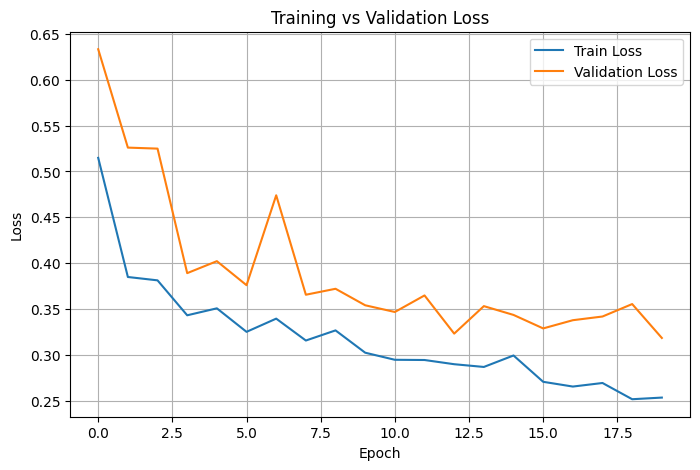

In [36]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


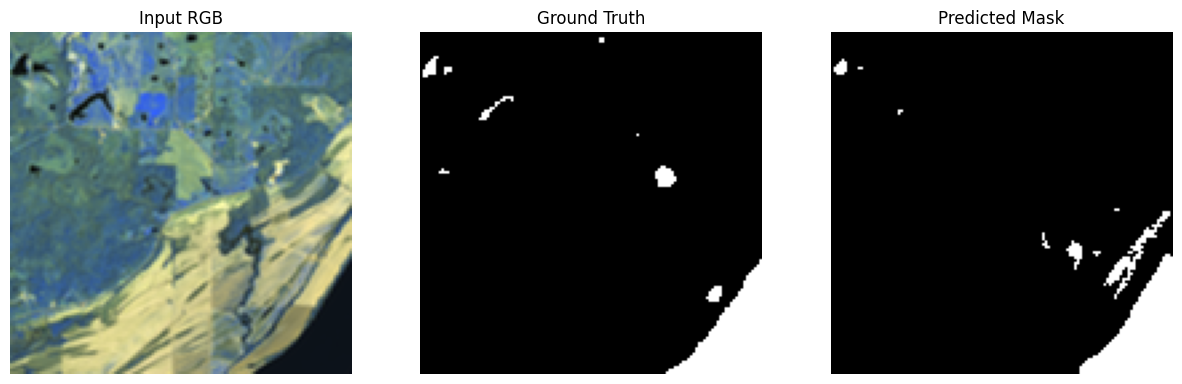

In [37]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[2], img[1], img[0]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


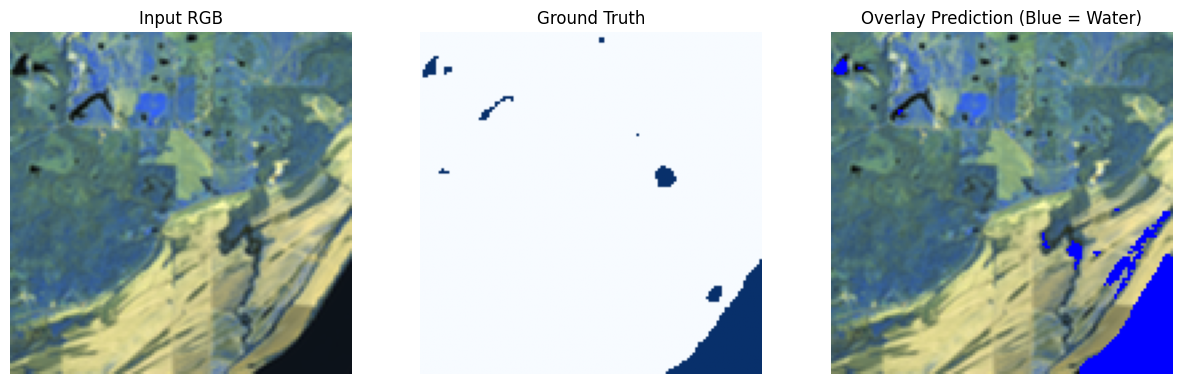

In [38]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()
